In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [2]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### 1 Import the kitchen sink

In [3]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../../src'))
import config ,config_pytorch
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [4]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [5]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
#from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob



In [6]:
## nnAudio
from nnAudio import features , Spectrogram
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.8/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [7]:
#torch.autograd.set_detect_anomaly(True)

In [8]:
#Global Training variables 
USE_SHORT_AUDIO = True
num_workers= 4
pin_memory=True
#train_size = 100
batch_size = 32
test_batch_size = 32
DEBUG = True
num_epochs = 200
if DEBUG:
    batch_size = 32
    test_batch_size = 4
    num_workers=0
    num_epochs = 4
    
     



In [9]:
# This function creates 1.92 secs rows of audio in a data frame format
# This function creates 1.92 secs rows of audio in a data frame format
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    #This is same as defined in config -min_duration = win_size * frame_duration
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    stride = step_frac*min_length
#     print("min_length = " +str(min_length))
#     print("step_frac = " +str(step_frac))
#     print("stride = " +str(stride))
    for _,row in df.iterrows():
        #processed_data keeps track of the tensor_values processed thus far
        if row['length'] > min_length:
            processed_data = 0
            #total_data is the total tensor present in the audio
            total_data = config.rate*row['length']
            #print("********")
            count = 0
#             print("count = " +str(count))
#             print("id = " + str(row['id']) + " duration = " +str(row['length']) + "total x vals = " + str(total_data))
            inner_loop_flag = False
            #print("going into the inner loop to offset....")
            while(processed_data < total_data):
                #print("inside inner loop.....")
                start = count*stride*config.rate
                #now find out the row_len
                if total_data - (start + min_length*config.rate) >= 0:
                    #print("full chunk ")
                    row_len = min_length
                    end = start + row_len*config.rate
                    audio_offsets.append({'id':row['id'], 'offset':count, 'length': row_len,'specie_ind': row['specie_ind'],'start':start,'end':end})
                    #print("count = " +str(count) + "offset = " +str(count) + "start = " +str(start) + "end = " +str(end))
                    #print("for count.... = " + str(count) + "processed data = " +str(processed_data))
                    count+=1
                    processed_data = (count*stride)*config.rate
                    
                else:
                    inner_loop_flag = True
                    break
                    
                                                       
            #for processing residual data
            if(inner_loop_flag):
                #print("processing residual ....processed " +str(processed_data) + " of " + str(total_data))
                start = count*stride*config.rate
                resid_durn = round((total_data - processed_data)/config.rate,2)
                end = total_data
                #print("for..." + str(row['id']) + " adding the residual data in the data frame with duration = " + str(resid_durn))
                audio_offsets.append({'id':row['id'], 'offset':count, 'length':resid_durn ,'specie_ind': row['specie_ind'],'start':start,'end':end})
            
        elif short_audio:
            start = 0
            end = row['length']*config.rate
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind'],'start':0 , 'end':end})
    return pd.DataFrame(audio_offsets)       

In [10]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]


### Read CSV and get train/test groups

In [11]:
# if DEBUG:
#     df = pd.read_csv(config.data_df_msc_test)
# else:
df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

id     length                             name  sample_rate  \
1       53   0.463456  CDC_Ae-aegypti_labelled_800.wav         8000   
2       57   0.170249  CDC_Ae-aegypti_labelled_800.wav         8000   
3       61   0.104041  CDC_Ae-aegypti_labelled_800.wav         8000   
4       69   0.274290  CDC_Ae-aegypti_labelled_800.wav         8000   
5       56   0.420894  CDC_Ae-aegypti_labelled_800.wav         8000   
...    ...        ...                              ...          ...   
8999  3562   6.083093                    #988-1001.wav        44100   
9000  3556   6.719908                    #988-1001.wav        44100   
9009  3553   6.128580                    #988-1001.wav        44100   
9011  3561  11.614280                    #988-1001.wav        44100   
9012  3552   2.920249                    #988-1001.wav        44100   

     record_datetime sound_type       species  gender  fed plurality  age  \
1      8/9/2016 8:00   mosquito    ae aegypti     NaN  NaN    Single  NaN   
2      8/9/2016 8:00   mosquito    ae aegypti     NaN  NaN    Single  NaN   
3      8/9/2016 8:00   mosquito    ae aegypti     NaN  NaN    Single  NaN   
4      8/9/2016 8:00   mosquito    ae aegypti     NaN  NaN    Single  NaN   
5      8/9/2016 8:00   mosquito    ae aegypti     NaN  NaN    Plural  NaN   
...              ...        ...           ...     ...  ...       ...  ...   
8999  1/7/2018 12:00   mosquito  an harrisoni  Female    t    Single  NaN   
9000  1/7/2018 12:00   mosquito  an maculatus  Female    t    Single  NaN   
9009  1/7/2018 12:00   mosquito  an maculatus  Female    t    Single  NaN   
9011  1/7/2018 12:00   mosquito  an harrisoni  Female    t    Single  NaN   
9012  1/7/2018 12:00   mosquito  an harrisoni  Female    t    Single  NaN   

     method mic_type    device_type   country          district  \
1       NaN    phone  Alcatel 4009X       USA           Georgia   
2       NaN    phone  Alcatel 4009X       USA           Georgia   
3       NaN    phone  Alcatel 4009X       USA           Georgia   
4       NaN    phone  Alcatel 4009X       USA           Georgia   
5       NaN    phone  Alcatel 4009X       USA           Georgia   
...     ...      ...            ...       ...               ...   
8999    ABN  telinga        olympus  Thailand  Sai Yok District   
9000    ABN  telinga        olympus  Thailand  Sai Yok District   
9009    ABN  telinga        olympus  Thailand  Sai Yok District   
9011    ABN  telinga        olympus  Thailand  Sai Yok District   
9012    ABN  telinga        olympus  Thailand  Sai Yok District   

                   province                            place location_type  
1                   Atlanta     CDC insect cultures, Atlanta       culture  
2                   Atlanta     CDC insect cultures, Atlanta       culture  
3                   Atlanta     CDC insect cultures, Atlanta       culture  
4                   Atlanta     CDC insect cultures, Atlanta       culture  
5                   Atlanta     CDC insect cultures, Atlanta       culture  
...                     ...                              ...           ...  
8999  Kanchanaburi Province  field site near Pu Teuy Village           cup  
9000  Kanchanaburi Province  field site near Pu Teuy Village           cup  
9009  Kanchanaburi Province  field site near Pu Teuy Village           cup  
9011  Kanchanaburi Province  field site near Pu Teuy Village           cup  
9012  Kanchanaburi Province  field site near Pu Teuy Village           cup  

[6008 rows x 19 columns]

In [12]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"



In [13]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
# other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
# df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [14]:
df.drop(df[df['specie_ind'] == "NULL_VAL"].index, inplace=True)
#other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
#df.loc[other_df_ind,'specie_ind']= other_ind        

At this stage we have all extracted the data with specie information and have encoded the specie encoding in a col = 'specie_ind'

In [15]:
#extracting the TZ and Cup data- this is as per the humbug paper

idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_all = df[idx_multiclass]

In [16]:
df_all.reset_index(inplace=True)

In [17]:
df_all

index      id  length                name  sample_rate record_datetime  \
0      1879  221103    2.56   IFA_17_24_664.wav        44100  30-01-20 00:00   
1      1880  221111    2.56   IFA_17_25_665.wav        44100  30-01-20 00:00   
2      1881  221110    2.56   IFA_17_25_665.wav        44100  30-01-20 00:00   
3      1882  221149    2.56   IFA_17_26_666.wav        44100  30-01-20 00:00   
4      1883  221150    2.56   IFA_17_26_666.wav        44100  30-01-20 00:00   
...     ...     ...     ...                 ...          ...             ...   
2283   4546  222615   30.72  IFA_86_39_3439.wav        44100  23-08-20 00:00   
2284   4547  222585   25.60  IFA_86_40_3440.wav        44100  23-08-20 00:00   
2285   4548  222586   40.90  IFA_87_10_3450.wav        44100  23-08-20 00:00   
2286   4549  222596   40.90  IFA_87_11_3451.wav        44100  23-08-20 00:00   
2287   4550  222614   38.40  IFA_87_12_3452.wav        44100  23-08-20 00:00   

     sound_type         species  gender fed  ... age  method mic_type  \
0      mosquito    ma africanus  Female   f  ... NaN     HBN  telinga   
1      mosquito    ma africanus  Female   f  ... NaN     HBN  telinga   
2      mosquito    ma africanus  Female   f  ... NaN     HBN  telinga   
3      mosquito   an arabiensis  Female   f  ... NaN     HBN  telinga   
4      mosquito   an arabiensis  Female   f  ... NaN     HBN  telinga   
...         ...             ...     ...  ..  ...  ..     ...      ...   
2283   mosquito  an funestus ss  Female   f  ... NaN      LT  telinga   
2284   mosquito  an funestus ss  Female   f  ... NaN      LT  telinga   
2285   mosquito  an funestus ss  Female   f  ... NaN      LT  telinga   
2286   mosquito  an funestus ss  Female   f  ... NaN      LT  telinga   
2287   mosquito  an funestus ss  Female   f  ... NaN      LT  telinga   

     device_type   country            district  province    place  \
0         tascam  Tanzania  Kilombero District  Morogoro  Ifakara   
1         tascam  Tanzania  Kilombero District  Morogoro  Ifakara   
2         tascam  Tanzania  Kilombero District  Morogoro  Ifakara   
3         tascam  Tanzania  Kilombero District  Morogoro  Ifakara   
4         tascam  Tanzania  Kilombero District  Morogoro  Ifakara   
...          ...       ...                 ...       ...      ...   
2283      tascam  Tanzania  Kilombero District  Morogoro  Ifakara   
2284      tascam  Tanzania  Kilombero District  Morogoro  Ifakara   
2285      tascam  Tanzania  Kilombero District  Morogoro  Ifakara   
2286      tascam  Tanzania  Kilombero District  Morogoro  Ifakara   
2287      tascam  Tanzania  Kilombero District  Morogoro  Ifakara   

     location_type specie_ind  
0              cup          7  
1              cup          7  
2              cup          7  
3              cup          0  
4              cup          0  
...            ...        ...  
2283           cup          3  
2284           cup          3  
2285           cup          3  
2286           cup          3  
2287           cup          3  

[2288 rows x 21 columns]

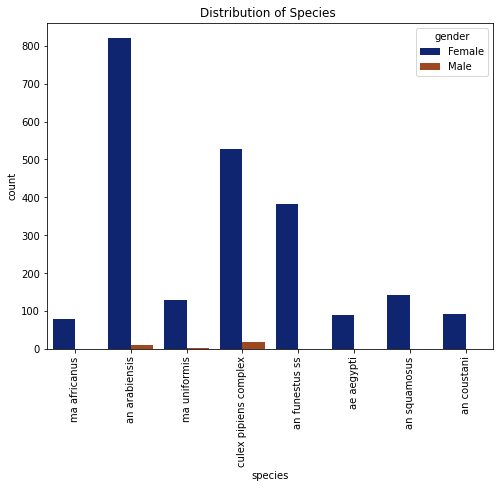

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
import seaborn as sns
sns.countplot(x = 'species', data = df_all , ax = ax , hue = 'gender',palette='dark')
#ax.bar_label(ax.containers[0])
#ax.bar_label(ax.containers[-1], fmt='Count:\n%.2f', label_type='center')
plt.xticks(rotation=90 )
plt.title("Distribution of Species ")
plt.rc('xtick', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('axes', labelsize=15)
plt.rc('figure', titlesize=15)

### Train-Test split( avoiding sklearn )

In [19]:
np.random.seed(1600)
msk_test = np.random.rand(len(df_all)) < 0.2
df_test = df_all[msk_test]
df_train_temp  = df_all[~msk_test]


In [20]:
np.random.seed(1600)
msk_train = np.random.rand(len(df_train_temp)) < 0.2
df_val = df_train_temp[msk_train]
df_train  = df_train_temp[~msk_train]

## Let's verify for data leakage by performing an inner-join on id

In [21]:
pd.merge(df_test,df_train, on = 'id', how = 'inner')

Empty DataFrame
Columns: [index_x, id, length_x, name_x, sample_rate_x, record_datetime_x, sound_type_x, species_x, gender_x, fed_x, plurality_x, age_x, method_x, mic_type_x, device_type_x, country_x, district_x, province_x, place_x, location_type_x, specie_ind_x, index_y, length_y, name_y, sample_rate_y, record_datetime_y, sound_type_y, species_y, gender_y, fed_y, plurality_y, age_y, method_y, mic_type_y, device_type_y, country_y, district_y, province_y, place_y, location_type_y, specie_ind_y]
Index: []

[0 rows x 41 columns]

In [22]:
pd.merge(df_test,df_val, on = 'id', how = 'inner')

Empty DataFrame
Columns: [index_x, id, length_x, name_x, sample_rate_x, record_datetime_x, sound_type_x, species_x, gender_x, fed_x, plurality_x, age_x, method_x, mic_type_x, device_type_x, country_x, district_x, province_x, place_x, location_type_x, specie_ind_x, index_y, length_y, name_y, sample_rate_y, record_datetime_y, sound_type_y, species_y, gender_y, fed_y, plurality_y, age_y, method_y, mic_type_y, device_type_y, country_y, district_y, province_y, place_y, location_type_y, specie_ind_y]
Index: []

[0 rows x 41 columns]

In [23]:
pd.merge(df_train,df_val, on = 'id', how = 'inner')

Empty DataFrame
Columns: [index_x, id, length_x, name_x, sample_rate_x, record_datetime_x, sound_type_x, species_x, gender_x, fed_x, plurality_x, age_x, method_x, mic_type_x, device_type_x, country_x, district_x, province_x, place_x, location_type_x, specie_ind_x, index_y, length_y, name_y, sample_rate_y, record_datetime_y, sound_type_y, species_y, gender_y, fed_y, plurality_y, age_y, method_y, mic_type_y, device_type_y, country_y, district_y, province_y, place_y, location_type_y, specie_ind_y]
Index: []

[0 rows x 41 columns]

We've confirmed that there is no recording that is common in Train,Test,val

### Next, we perform "offsets", spliting each(long) recording into multiple 1.92 secs chunk. 

In [24]:
df_train_offset = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
df_test_offset = get_offsets_df(df_test, short_audio=USE_SHORT_AUDIO)
df_val_offset = get_offsets_df(df_val, short_audio=USE_SHORT_AUDIO)

In [25]:
print("length of train offset = " +str(len(df_train_offset)))
print("length of test offset = " +str(len(df_test_offset)))
print("length of val offset = " +str(len(df_val_offset)))

length of train offset = 36662
length of test offset = 10393
length of val offset = 8497


In [26]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



### Let's check for data leakage in offsets

In [27]:
pd.merge(df_train_offset , df_test_offset , on = 'id', how = 'inner')

Empty DataFrame
Columns: [index_x, id, offset_x, length_x, specie_ind_x, start_x, end_x, index_y, offset_y, length_y, specie_ind_y, start_y, end_y]
Index: []

In [28]:
pd.merge(df_train_offset , df_val_offset , on = 'id', how = 'inner')

Empty DataFrame
Columns: [index_x, id, offset_x, length_x, specie_ind_x, start_x, end_x, index_y, offset_y, length_y, specie_ind_y, start_y, end_y]
Index: []

In [29]:
pd.merge(df_test_offset , df_val_offset , on = 'id', how = 'inner')

Empty DataFrame
Columns: [index_x, id, offset_x, length_x, specie_ind_x, start_x, end_x, index_y, offset_y, length_y, specie_ind_y, start_y, end_y]
Index: []

### At this stage we've a dataframe of recordin ids and each row corresponds to a 1.92 secs recording or shorter


In [30]:
def get_specie_distri(df , classes , type_df = None):
    """This function takes a dataframe and provides a count of each specie class"""
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [31]:
#Class imbalance 
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.31857838 0.6120943  3.02691546 0.59960094 2.22896401 4.1286036
 2.72945205 5.81567259]


Let us now get the class distribution for each of the dataframes- train,test and val

In [32]:
get_specie_distri(df_train_offset , classes , type_df = "train")


DF type = train
i = 0
14385
DF type = train
i = 1
7487
DF type = train
i = 2
1514
DF type = train
i = 3
7643
DF type = train
i = 4
2056
DF type = train
i = 5
1110
DF type = train
i = 6
1679
DF type = train
i = 7
788


In [33]:
get_specie_distri(df_val_offset , classes , type_df = "Val")

DF type = Val
i = 0
3344
DF type = Val
i = 1
1825
DF type = Val
i = 2
141
DF type = Val
i = 3
1626
DF type = Val
i = 4
465
DF type = Val
i = 5
411
DF type = Val
i = 6
531
DF type = Val
i = 7
154


In [34]:
get_specie_distri(df_test_offset , classes , type_df = "test")

DF type = test
i = 0
4364
DF type = test
i = 1
2759
DF type = test
i = 2
306
DF type = test
i = 3
1826
DF type = test
i = 4
572
DF type = test
i = 5
152
DF type = test
i = 6
218
DF type = test
i = 7
196


In [35]:
# This function pads a short-audio tensor with its mean to ensure that it becomes a 1.92 sec long audio equivalent
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add.shape))
        #print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add.shape))
        #print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [36]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(len(classes)))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [37]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### Class Defintions

In [38]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [39]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [40]:
df_train_offset.head()

index      id  offset  length  specie_ind    start      end
0      0  221103       0    1.92           7      0.0  15360.0
1      1  221103       1    1.92           7   5120.0  20480.0
2      2  221103       2    1.28           7  10240.0  20480.0
3      3  221111       0    1.92           7      0.0  15360.0
4      4  221111       1    1.92           7   5120.0  20480.0

In [41]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    softmax = nn.Softmax()
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print(" $$$$$$$$inside test$$$$$$$$....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            has_nan = torch.isnan(x).any().item()
            more_than_1 = torch.max(x)
            assert not(has_nan) ,"Tensor contains NaN values in TEST SET ."
            assert not(more_than_1 > 1), "Tensor contain values greater than 1 in TEST SET ."
            if DEBUG:
                print("y = " + str(y))
            output = model(x,train = False)
            y_pred = output['probs']
            #y_pred_smax = softmax(y_pred)
            preds = output['preds']
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
            print(" $$$$$$$$ exiting test$$$$$$$$....")
        
        test_loss = test_loss
        is_loss_nan = torch.isnan(torch.tensor(test_loss))
        assert not(torch.isnan(is_loss_nan)) , "NAN in TEST LOSS"
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred

In [42]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    
    global_step = 0
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    from torch.optim.lr_scheduler import CosineAnnealingLR
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    #optimiser = timm.optim.create_optimizer_v2(model.parameters(), lr= .0001,opt = 'lookahead_adam')
    base_optimiser = timm.optim.AdamP(model.parameters(), lr= 1e-4)
    lookahead_optimiser = timm.optim.Lookahead(base_optimiser)
    #scheduler = CosineAnnealingLR(optimiser, T_max=num_epochs, eta_min= 1e-6)
    scheduler = timm.scheduler.CosineLRScheduler(base_optimiser, t_initial=num_epochs/2,lr_min= 1e-5,cycle_decay = .25,warmup_t = 5 ,warmup_lr_init = 1e-5)
    #timm.optim.Lookahead(optimiser, alpha=0.5, k=6)
    
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    softmax = nn.Softmax()
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        loss_nan_flag = False
        #running_loss = 0.0
        all_y = []
        all_y_pred = []
        for batch_i, inputs in enumerate(train_loader):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 500 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            has_nan = torch.isnan(x).any().item()
            assert not(has_nan) ,"Tensor contains NaN values in TRAIN."
            if DEBUG:
                print("inside train loop.. x device = " +str(x.device))
            y = inputs[1].type(torch.LongTensor).to(device)
             
            with autocast():
                output = model(x,train = True)
                y_pred = output['probs']
                preds = output['preds']
                loss = criterion(y_pred, y)
            
            if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                
            train_loss += loss.item()
            if DEBUG:
                print("loss = ",loss.item())
            is_loss_nan = torch.isnan(loss)
            current_lr = base_optimiser.param_groups[0]['lr']
            lr_log.append(current_lr)
            loss_nan_flag = True
            if is_loss_nan:
                print("NAN encountered returning ...")
                return model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1
                
            
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            base_optimiser.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),error_if_nonfinite=False ,max_norm = 5.0 )
            base_optimiser.step()
            del x
            del y
            del y_pred,preds
        
        #lr_log.append(lr)
        lookahead_optimiser.sync_lookahead()
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        all_train_f1.append(train_f1)
        if DEBUG:
            print("train_f1 = " +str(train_f1))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        all_val_f1.append(val_f1)
        all_val_loss.append(val_loss)
        if DEBUG:
            print("val F1 = " + str(val_f1))
        all_val_loss.append(val_loss)
        all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        scheduler.step(e+1)
        
        if acc_metric > best_acc_metric:  
            overrun_counter = -1
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir,  checkpoint_name))
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
            print('Saving model to:', os.path.join(config.model_dir,  checkpoint_name)) 
            print("Now printing classification rport... ")
            print("********************************")
            from sklearn.metrics import classification_report
            test_loss, test_f1 , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            # at times output is not getting printed. Could be due to multi threading and hence adding sleep
            time.sleep(2)
            sys.stdout.flush()
            print("test_loss = ",str(test_loss/len(test_loader)))
            print("test_f1 = ",str(test_f1))
            print("LR log = ",lr_log[-1])
            
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            print("********************************")
            
            time.sleep(2)
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_f1 = val_f1
            best_val_loss = val_loss
            
        else:
            print("..Overrun....no improvement")
            overrun_counter += 1
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1

In [43]:
# from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization
# #apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])


# apply_augmentation = Compose(transforms=[AddColoredNoise(p = 1) ,TimeInversion( p = 1) ,PolarityInversion(p = 1)])

# #apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])

In [44]:
class MozDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        temp_id = int(self.audio_df.loc[idx]['id'])
        path_var = self.data_dir +"/" +str(temp_id)+ str(".wav")
        entire_aud, inp_rate = torchaudio.load(path_var)
        if inp_rate != config.rate:
            #print(" Original sample rate = " +str(inp_rate)+ " resampling ...")
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=entire_aud.dtype)
            entire_aud = resampler(entire_aud)
            #print("processsing file on " +str(path_var) + "Post resample shape =  " + str(entire_aud.shape))
        
        aud_len = self.audio_df.loc[idx]['length']
        offset = int(self.audio_df.loc[idx]['offset'])
        #print("sliced val = " +str(int((offset+config.min_duration)*config.rate)))
        start_pos = int(round(self.audio_df.loc[idx]['start']))
        #print("start_pos = " +str(start_pos))
        end_pos =  int(round(self.audio_df.loc[idx]['end']))
        #print("end_pos = " +str(end_pos))
        x = entire_aud[:,start_pos:end_pos]
        #print("extracted x = " +str(x))
        #print("x shape = " +str(x.shape))
        if aud_len < config.min_duration:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            #print("padding on " +str(path_var))
            f_out = pad_mean(x)
            #print("returning from padding  SHape = " +str(f_out.shape))
        else:
            f_out = x[0]
            f_out = f_out.unsqueeze(0)
            
        if DEBUG:
            print("idx = " + str(idx))
            #print("offset = " + str(offset))
            #print("shape of x post augmentation = " + str(x.shape))
            print("from get_item of train, returning  x of shape = " +str(f_out.shape))
        
        #x_val = x[:,start:end]
        #now that we have final x- let's create specgram and add augmentations.
                 
        return (f_out,self.audio_df.loc[idx]['specie_ind'] )


In [45]:
import torch.nn as nn
import torchvision.transforms as transforms

class ApplyAug(nn.Module):
    def __init__(self):
        super().__init__()
        self.aug_flag_y = transforms.Compose([
            transforms.GaussianBlur(3),
            transforms.RandomErasing(),
            #transforms.Normalize(mean=2.7360104e-05, std=.0061507192)
        ])
        
        
    def forward(self, spec_gram, aug_flag):
        if aug_flag == "Y":
            rgb_img_auto_aug = self.aug_flag_y(spec_gram)
            return rgb_img_auto_aug
        else:
            return spec_gram

In [46]:
class Normalize_batch(nn.Module):
    def __init__(self):
        super(Normalize_batch, self).__init__()
        
    def forward(self, x):
        batch_mean = torch.mean(x, dim=0, keepdim=True)
        batch_std = torch.std(x, dim=0, keepdim=True)
        epsilon = 1e-8
        batch_std = torch.sqrt(batch_std ** 2 + epsilon)
        batch_normalized = (x - batch_mean) / batch_std
        return batch_normalized
        

In [47]:
class SpecAug_All(nn.Module):
    def __init__(self):
        super(SpecAug_All, self).__init__()
        self.transformations = nn.Sequential(
            transforms.RandomApply([
                torchaudio.transforms.FrequencyMasking(freq_mask_param=100),
                torchaudio.transforms.TimeMasking(time_mask_param=25)
                
            ], p=0.05),  # Example probability of applying the transformations
            # Additional transformations or layers can be added here
        )

    def forward(self, x):
        x = self.transformations(x)
        print("$$$$$ Inside SPEC_AUG ALL $$$$$$")
        return x


In [48]:
class FreqMask(nn.Module):
    def __init__(self):
        super(FreqMask, self).__init__()
        self.transformations = nn.Sequential(
            transforms.RandomApply([
                torchaudio.transforms.FrequencyMasking(freq_mask_param=100),
                ], p=0.15),  # Example probability of applying the transformations
            # Additional transformations or layers can be added here
        )
        

    def forward(self, x):
        x = self.transformations(x)
        print("^^^^Inside FREQ MASK^^^^ ")
        return x


In [49]:
class TimeMask(nn.Module):
    def __init__(self):
        super(TimeMask, self).__init__()
        self.transformations = nn.Sequential(
            transforms.RandomApply([
                torchaudio.transforms.TimeMasking(time_mask_param=25)
                ], p=0.15),  # Example probability of applying the transformations
            # Additional transformations or layers can be added here
        )
        

    def forward(self, x):
        x = self.transformations(x)
        print("^^^^Inside TimeMask MASK^^^^ ")
        return x


In [50]:
# Subclass the pretrained model and make it a binary classification
class MyModel(nn.Module):
    def __init__(self, model_name ,input_size = 4, hidden_size = 768 , num_classes = 8 , image_size = 224 , batch_size = batch_size):
        super(MyModel, self).__init__()

        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=8, in_chans=1, 
                        drop_path_rate=0.2, global_pool='max',
                        drop_rate=0.25)
        self.spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=True,verbose = False,fmin = 100,fmax = 2000)
        #self.linear = nn.Linear(hidden_size , 1024)
        self.output = nn.Linear(1000, num_classes)
        self.sizer = VT.Resize((image_size,image_size),antialias = True)
        self.softmax = nn.Softmax(dim = 1)
        self.TimeMask_layer = TimeMask()
        self.FreqMask_layer = FreqMask()
        self.SpecAug_All_layer = SpecAug_All()
        self.norm_layer = Normalize_batch()
        
        

    def forward(self, input_ids,train = True ,attention_mask = False):
        #this will hold the output
        output_dict = {'probs':None , 'preds':None}
        max_input_wav,_ = torch.max(input_ids,dim =2)
        min_input_wav,_ = torch.min(input_ids,dim =2)
        
        if DEBUG:
            print("shape of input = ",input_ids.shape)
            print("max_input_wav = ", max_input_wav)
            print("min_input_wav = ", min_input_wav)
            
        spec_gram = self.spec_layer(input_ids)
        spec_gram_nan_check = torch.isnan(spec_gram).any().item()
        min_val_spec_gram = torch.min(spec_gram)
        max_val_spec_gram = torch.max(spec_gram)
        assert not(max_val_spec_gram < 0) , "neg value in the output of spectrogram" 
        assert not (spec_gram_nan_check) ,"Tensor contains NaN values after spec gram creation."
        if DEBUG:
            print("post STFT , spec gram = ", spec_gram)
            print("post STFT , spec gram max val = ", torch.max(spec_gram))
            print("post STFT , spec gram min val = ", torch.min(spec_gram))
            print("post STFT , spec_gram_nan_check = ", spec_gram_nan_check)
                 
        if train== True:
            spec_gram = self.FreqMask_layer(spec_gram)
            spec_gram = self.TimeMask_layer(spec_gram)
            spec_gram = self.SpecAug_All_layer(spec_gram)
                        
            
        spec_gram_nan_check = torch.isnan(spec_gram).any().item()
        assert not (spec_gram_nan_check) ,"Tensor contains NaN values after aug layer Y "
        del spec_gram_nan_check,min_val_spec_gram,max_val_spec_gram,max_input_wav,min_input_wav
        if DEBUG:
            #print("post aug_layer N , spec gram = ", spec_gram)
            print("post aug_layer flag N , spec gram max val = ", torch.max(spec_gram))
            print("post aug_layer flag N, spec gram min val = ", torch.min(spec_gram))
            
            
        # now reshape to image_size
        spec_gram = spec_gram.view(batch_size,1,-1)
        spec_gram = self.sizer(spec_gram)
        spec_gram = spec_gram.unsqueeze(dim = 1)
        normalized_spec_gram = self.norm_layer(spec_gram)
        
                
        if DEBUG:
            print("normalized_spec_gram = ",normalized_spec_gram)
            print("post sizer shape of spec_gram = " , spec_gram.shape)
            print("post Norm  , normalized_spec_gram max = ", torch.max(normalized_spec_gram))
            print("post Norm  , normalized_spec_gram min = ", torch.min(normalized_spec_gram))
            #now make it 3 channel 
        #spec_gram = torch.cat((spec_gram, spec_gram, spec_gram), dim=1).to('cuda')
        #del mean,std
        backbone_op = self.backbone(normalized_spec_gram)
        #print("backbone_op = ",backbone_op)
        backbone_op_nan_check = torch.isnan(backbone_op).any().item()
        assert not (backbone_op_nan_check) ,"Tensor contains NaN values in the backbone OP "
        if DEBUG:
            print("backbone_op shape ",backbone_op.shape)
            print("backbone_op = ", backbone_op)
        out_smax = self.softmax(backbone_op)
        if DEBUG:
            print("out_smax = ",out_smax)
            print("out_smax shape = " , out_smax.shape)
        #out_smax = self.softmax(output)
        out = torch.argmax(out_smax , dim = 1)
        #print("out = ",out)
        
        output_dict['probs'] = out_smax
        output_dict['preds'] = out
        #print("^^^^^ inside forward^^^^^^^")
        del spec_gram
        if DEBUG:
            print("output_dict = ", output_dict)
        return output_dict

In [51]:
def get_indices(num_values ,df ,classes = classes):
    new_df = pd.DataFrame()
    for ind in range(len(classes)):
        #print("ind = ", ind)
        op = df[df['specie_ind'] == ind]
        #print("len op = ", len(op))
        op_new = op.sample(n = 1)
        #print("rand_ind = " , rand_ind)
        #([df1, df2], axis=1)
        new_df = pd.concat([op_new,new_df],axis = 0)
        #print("elem = " , elem)
        #new_list.append(elem)
    if len(new_df) < num_values:
        diff =  num_values - len(new_df)
        #print("diff = ", diff)
        remaining_elems= df.sample(n = diff)
        #print("len of remaining elems = ", len(remaining_elems))
        new_df = pd.concat([remaining_elems,new_df],axis = 0)
        
    #print("new_df = ", new_df)    
    new_df_1 = new_df.reset_index(drop = True)
    return new_df_1

In [52]:
df_train_offset

index      id  offset  length  specie_ind     start       end
0          0  221103       0    1.92           7       0.0   15360.0
1          1  221103       1    1.92           7    5120.0   20480.0
2          2  221103       2    1.28           7   10240.0   20480.0
3          3  221111       0    1.92           7       0.0   15360.0
4          4  221111       1    1.92           7    5120.0   20480.0
...      ...     ...     ...     ...         ...       ...       ...
36657  36657  222614      54    1.92           3  276480.0  291840.0
36658  36658  222614      55    1.92           3  281600.0  296960.0
36659  36659  222614      56    1.92           3  286720.0  302080.0
36660  36660  222614      57    1.92           3  291840.0  307200.0
36661  36661  222614      58    1.28           3  296960.0  307200.0

[36662 rows x 7 columns]

In [53]:
print(config.data_dir)
if DEBUG:
    print(DEBUG)
    df_train_offset_db = get_indices(batch_size*100,df_train_offset)
    df_val_offset_db = get_indices(batch_size*100,df_val_offset)
    df_test_offset_db = get_indices(batch_size*100,df_test_offset)
    
    train_dataset_db = MozDataset(df_train_offset_db,  config.data_dir, min_length)
    val_dataset_db = MozDataset(df_val_offset_db,  config.data_dir, min_length)
    test_dataset_db = MozDataset(df_test_offset_db,  config.data_dir, min_length)
    #error_dataset = MozErrAnalysisDataset(df_val_offset,  config.data_dir, min_length = config.min_duration)

    train_loader = torch.utils.data.DataLoader(train_dataset_db, num_workers=num_workers,batch_size = batch_size,shuffle = True, pin_memory=True,drop_last = True )
    val_loader = torch.utils.data.DataLoader(val_dataset_db, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory,drop_last = True )
    test_loader = torch.utils.data.DataLoader(test_dataset_db, batch_size=batch_size,num_workers= num_workers, pin_memory=pin_memory,drop_last = True)
    #error_loader = torch.utils.data.DataLoader(error_dataset, batch_size=batch_size,num_workers= num_workers, pin_memory=pin_memory,drop_last = True)
    print("Length of train dataset = " +str(len(train_dataset_db)))
    print("Length of train loader = " +str(len(train_loader)))
    print("Length of val dataset = " +str(len(val_dataset_db)))
    print("Length of val loader = " +str(len(val_loader)))
    print("Length of test dataset = " +str(len(test_dataset_db)))
    print("Length of test loader = " +str(len(test_loader)))

else:
    train_dataset = MozDataset(df_train_offset,  config.data_dir, min_length)
    val_dataset = MozDataset(df_val_offset,  config.data_dir, min_length)
    test_dataset = MozDataset(df_test_offset,  config.data_dir, min_length)
    error_dataset = MozErrAnalysisDataset(df_val_offset,  config.data_dir, min_length = config.min_duration)

    train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True, pin_memory=True,drop_last = True )
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory,drop_last = True )
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,num_workers= num_workers, pin_memory=pin_memory,drop_last = True)
    error_loader = torch.utils.data.DataLoader(error_dataset, batch_size=batch_size,num_workers= num_workers, pin_memory=pin_memory,drop_last = True)

    



../../data/audio
True
Length of train dataset = 3200
Length of train loader = 100
Length of val dataset = 3200
Length of val loader = 100
Length of test dataset = 3200
Length of test loader = 100


In [54]:
print(len(train_loader))

100


In [55]:
# train_itr = iter(train_loader)
# a,b = train_itr.next()
# print(a.shape)
# print(b)

In [56]:
# spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
#                               window='hann', freq_scale='linear', center=True, pad_mode='reflect',
#                            sr=config.rate, output_format="Magnitude", trainable=True,)
# x = spec_layer(a)

In [57]:
#test_mod = Model('convnext_small',224)



In [58]:
# test_mod(a)


## Training

In [59]:
def load_model(filepath, model=MyModel('convnext_xlarge_in22k')):
    # Instantiate model to inspect
    print("Filepath = " + str(filepath))
    print("model = " +str(model))
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

In [ ]:
#model =MyModel('convnext_xlarge_in22k')
model =MyModel('convnext_xlarge_in22k',224)
#filepath = "../../models/model_e2_2023_03_31_15_47_38.pth"
#model_epcoh_99 = load_model(filepath,model)
model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1 = train_model(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )

Training on cuda:0
idx = 490
from get_item of train, returning  x of shape = torch.Size([1, 15360])
idx = 2220
from get_item of train, returning  x of shape = torch.Size([1, 15360])
idx = 710
from get_item of train, returning  x of shape = torch.Size([1, 15360])
idx = 1105
from get_item of train, returning  x of shape = torch.Size([1, 15360])
idx = 687
from get_item of train, returning  x of shape = torch.Size([1, 15360])
idx = 807
from get_item of train, returning  x of shape = torch.Size([1, 15360])
idx = 1473
from get_item of train, returning  x of shape = torch.Size([1, 15360])
idx = 1393
from get_item of train, returning  x of shape = torch.Size([1, 15360])
idx = 2854
from get_item of train, returning  x of shape = torch.Size([1, 15360])
idx = 834
from get_item of train, returning  x of shape = torch.Size([1, 15360])
idx = 361
from get_item of train, returning  x of shape = torch.Size([1, 15360])
idx = 1690
from get_item of train, returning  x of shape = torch.Size([1, 15360])
idx

In [ ]:
print("len of all_train_f1 = "+str(len(all_train_f1)))
print("len of all_val_f1 = "+str(len(all_val_f1)))
print("len of all_val_loss = "+str(len(all_val_loss)))
print("len of all_train_loss = "+str(len(all_train_loss)))


In [ ]:
all_val_f1_final =  [v for i, v in enumerate(all_val_f1) if i % 2 == 0]



In [ ]:
all_val_loss_final =  [v for i, v in enumerate(all_val_loss) if i % 2 == 0]

In [ ]:
all_train_f1_final =  [v for i, v in enumerate(all_train_f1) if i % 2 == 0]

In [ ]:
len(all_train_f1_final)

In [ ]:
len(all_train_f1)

In [ ]:
plot_df = pd.DataFrame({'train_loss':all_train_loss})

In [ ]:
plot_df['val_f1'] = all_val_f1_final

In [ ]:
plot_df['train_f1'] = all_train_f1_final

In [ ]:
plot_df['val_loss'] = all_val_loss_final

In [ ]:
#df.fillna(0)
plot_df.fillna(0)

In [ ]:
plot_df.iloc[129]

In [ ]:
#sns.lineplot(plot_df['train_f1','val_f1']);
plt.figure(figsize=(8,6)) 
sns.lineplot(plot_df[['train_f1','val_f1']])
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score - ConvNext Small")



In [ ]:
plt.figure(figsize=(8,6)) 
sns.lineplot(plot_df[['train_loss','val_loss']])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss - ConvNext Small")

In [ ]:
#df.to_csv('file1.csv')
plot_df.to_csv("plot_df_convNext_small.csv")

In [ ]:
len(all_val_f1)

In [ ]:
print(len(all_train_f1))

In [ ]:
val_dataset_new = MozTestDataset(df_val_offset,  config.data_dir, min_length)
val_loader_new = torch.utils.data.DataLoader(
        val_dataset, batch_size=2,
        num_workers=0, pin_memory=pin_memory  )



In [ ]:
df_error = df_val_offset
model = model_epcoh_10
model.to('cuda')
model.eval()
for idx,(x,y) in enumerate(val_dataset):
    print(idx)
    print(y)
    x = x.to('cuda').float()
    print("x shape = " +str(x.shape))
    #x_new = x.unsqueeze(dim = 1)
    print("x_new shape = " +str(x_new.shape))
    x_new = x.to('cuda')
    y_pred = model(x_new)['prediction']
    y_pred_cpu = y_pred.cpu().detach()
    preds = torch.argmax(y_pred_cpu, axis = 1)
    df_erroriloc[idx]['y_hat'] = preds
    del x_new
    

    

In [ ]:
x = torch.rand(1,15360)
x = x.unsqueeze(dim = 1)

In [ ]:
df_val_offset.head()
path_temp = "../data/audio/"
for i,row in df_val_offset.iterrows():
    print("i = " +str(i))
    print("id = " + str(int(row['id'])))
    file = str(int(row['id']))+".wav"
    print(file)
    path = path_temp + file
    waveform, inp_rate = torchaudio.load(path)
    if inp_rate != config.rate:
        import torchaudio.transforms as T
        resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
        waveform = resampler(waveform)
    if waveform.shape[1] < config.rate*min_length:
        #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
        f_out = pad_mean(waveform)
    else:
        f = waveform[0]
        f_out = f.unsqueeze(0)
    
    
               

In [ ]:
def get_tensor(df):
    
    path_name = "../data/audio/"
    file = df.loc[idx]['id'])}.wav")
    waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("")
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        
        if DEBUG:
            print("shape of x post augmentation = " + str(x.shape))
            
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("returning x of shape ..." + str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [ ]:
#Take the model checkpoint as a parameter as input
# read the val df
#get the tensor rep for the offset.
#pass it to the model get add get the prediction.


In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))